#Analyse des données de consomation

In [10]:
import numpy as np
#import pandas as pd
import datetime as dt
#import streamlit as st
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
conso_file = open(r"Data\RES2-6-9.csv")
file_data = conso_file.readlines()[1:]

In [12]:
DATA=[]
for i in file_data:
    line = i.split(';')
    line[0]  = int(line[0])
    line.append(float(line[2][:-1]))
    time = line[1]
    line[1] = dt.date(int(time[:4]), int(time[5:7]), int(time[8:10]))
    line[2] =time[10:]
    DATA.append(line)
test = DATA[0]
print(test)
print(type(test[1]))

[476866365062, datetime.date(2023, 11, 1), ' 00:00:00+01:00', 1328.1]
<class 'datetime.date'>


#Traitement de donne

In [13]:
IDS=set()
N_day = 365
moy_indiv={}
conso_indiv = {}
line_indiv = {}
for line in DATA:
    id = line[0]
    if id not in IDS:
        IDS.add(id)
        moy_indiv[id] = line[3]/N_day
        conso_indiv[id] = [line[3]]
        line_indiv[id] = [line]

    else:
        moy_indiv[id]+=line[3]/N_day
        conso_indiv[id].append(line[3])
        line_indiv[id].append(line)

ecart_type_indiv = {i: np.std(conso_indiv[i]) for i in conso_indiv.keys()}


In [27]:
def isweekend(date: dt.date) -> bool: 
    """Check if date is in weekend"""
    if 5<date.weekday():
        return True
    return False

def issummer(date: dt.date) -> bool:
    """Check if date is in summer (June to Aug)"""
    if 5<date.month<9:
        return True
    return False 

def iswinter(date: dt.date) -> bool:
    """Check if date is in winter (Nov to Feb)"""
    if date.month<2 or date.month>10:
        return True
    return False 

In [ ]:
#Sorting by day
#dict(int :dict(dt.date: float))
conso_id_day = {}
for id in IDS:
    conso_list = line_indiv[id]
    seen_day = set()
    conso_day = {}
    for i in conso_list:
        day = i[1]
        if day not in seen_day:
            seen_day.add(day)
            conso_day[day] = i[3]
        else:
            conso_day[day] += i[3]
    conso_id_day[id] = conso_day


#Calcul du rapport de conso we/sem

In [19]:
mult_we_indiv = {} #Ratio conso moyenne journée we / conso moyenne journée semaine 
for id in conso_id_day.keys():
    conso_day = conso_id_day[id] 
    conso_sem = [0, 0]
    num_day = [0, 0]
    for day in conso_day.keys():
        if isweekend(day):
            conso_sem[1] += conso_day[day]
            num_day[1] += 1
        else:
            conso_sem[0] += conso_day[day]
            num_day[0] += 1
    moy_sem = [0, 0]
    for i in range(2):
        if num_day[i]!=0:
            moy_sem[i] = conso_sem[i]/num_day[i]
        else:
            moy_sem[i] = 0
    mult_we: float = moy_sem[1]/(moy_sem[0]+0.001)
    mult_we_indiv[id] = mult_we
    


#Calcul du rapport conso été/conso hiver

In [55]:
mult_seas_indiv = {}
for id in conso_id_day.keys():
    conso_day = conso_id_day[id]
    conso_seas = [0, 0]
    num_day = [0, 0] #Summer Winter
    for day in conso_day.keys():
        if issummer(day):
            num_day[0] += 1
            conso_seas[0] += conso_day[day]
        elif iswinter(day):
            num_day[1] += 1
            conso_seas[1] += conso_day[day]
    moy_seas = [0, 0]
    for i in range(2):
        if num_day[i]!=0:
            moy_seas[i] = conso_seas[i]/num_day[i]
        else:
            moy_seas[i] = 0

    mult_seas: float = moy_seas[0]/(moy_seas[1]+0.001)
    
   
    mult_seas = np.log(mult_seas) 
    mult_seas_indiv[id] = mult_seas


#Modèle de KMeans

In [ ]:
y = np.array([mult_we_indiv[i] for i in IDS])
x = np.array([mult_seas_indiv[i] for i in IDS])



X = np.column_stack((x, y))
X_train, X_test = train_test_split(X, test_size=0.33, random_state=0)
kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans.fit(X_train)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


In [ ]:
, random_state = 0, n_init='auto')
kmeans.fit(X_train)

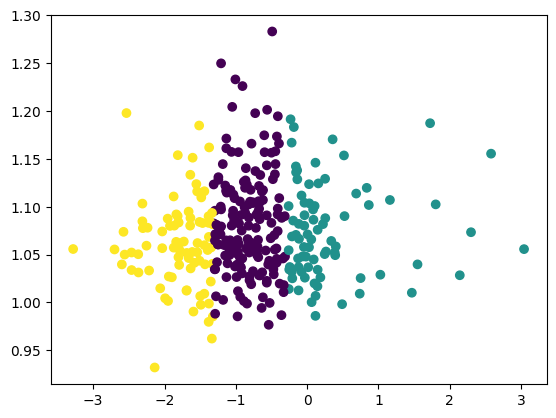

In [57]:
labels = kmeans.predict(X_train)

plt.scatter(X_train[:,0], X_train[:,1], c=labels)
plt.show()

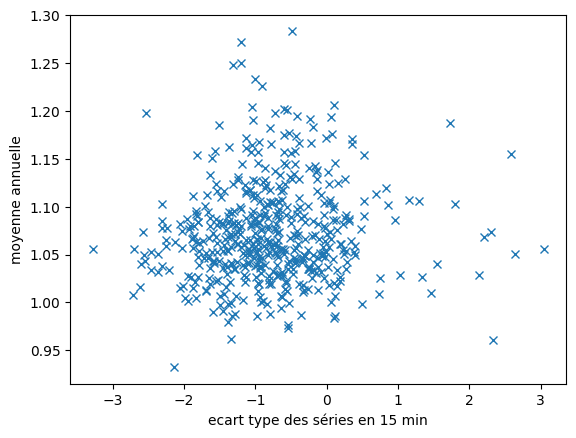

In [58]:
plt.plot(x,y,'x')
plt.xlabel("ecart type des séries en 15 min")
plt.ylabel("moyenne annuelle")
plt.show()